In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self, ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

3


{'ZOGY': {'FP': 4, 'FN': 30, 'TP': 20}, 'ALstack': {'FP': 1, 'FN': 31, 'TP': 19}, 'SZOGY': {'FP': 7, 'FN': 35, 'TP': 15}, 'ALstack_noDecorr': {'FP': 3, 'FN': 28, 'TP': 22}}


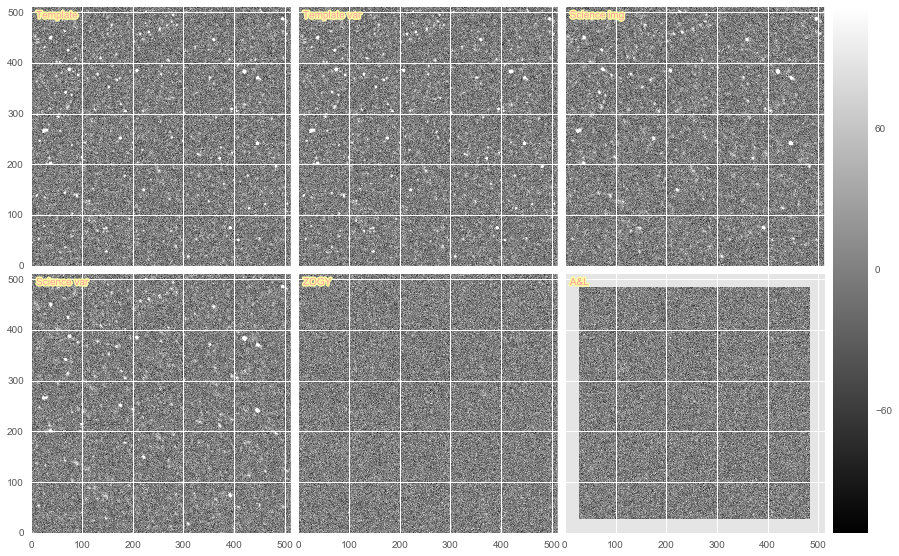

In [2]:
reload(dit);
testObj = dit.DiffimTest()
res = testObj.runTest()
print res
fig = plt.figure(1, (15, 15))
testObj.doPlot()

## Test out new options.

First, `templateNoNoise`.

{'ZOGY': {'FP': 6, 'FN': 20, 'TP': 30}, 'ALstack': {'FP': 4, 'FN': 29, 'TP': 21}, 'SZOGY': {'FP': 8, 'FN': 23, 'TP': 27}, 'ALstack_noDecorr': {'FP': 4, 'FN': 22, 'TP': 28}}


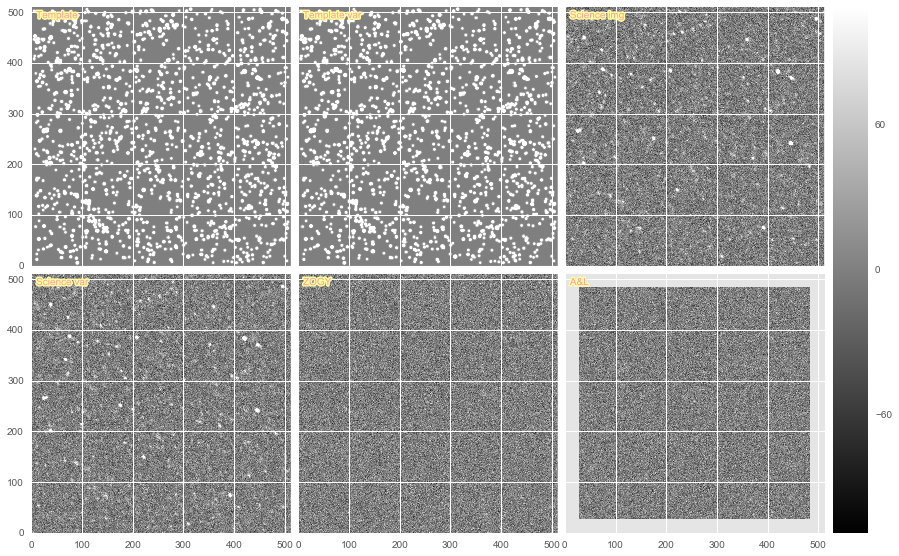

In [3]:
reload(dit);
testObj = dit.DiffimTest(templateNoNoise=True)
res = testObj.runTest()
print res
fig = plt.figure(1, (15, 15))
testObj.doPlot()

Next, `skyLimited`.

{'ZOGY': {'FP': 4, 'FN': 30, 'TP': 20}, 'ALstack': {'FP': 2, 'FN': 32, 'TP': 18}, 'SZOGY': {'FP': 9, 'FN': 33, 'TP': 17}, 'ALstack_noDecorr': {'FP': 2, 'FN': 29, 'TP': 21}}


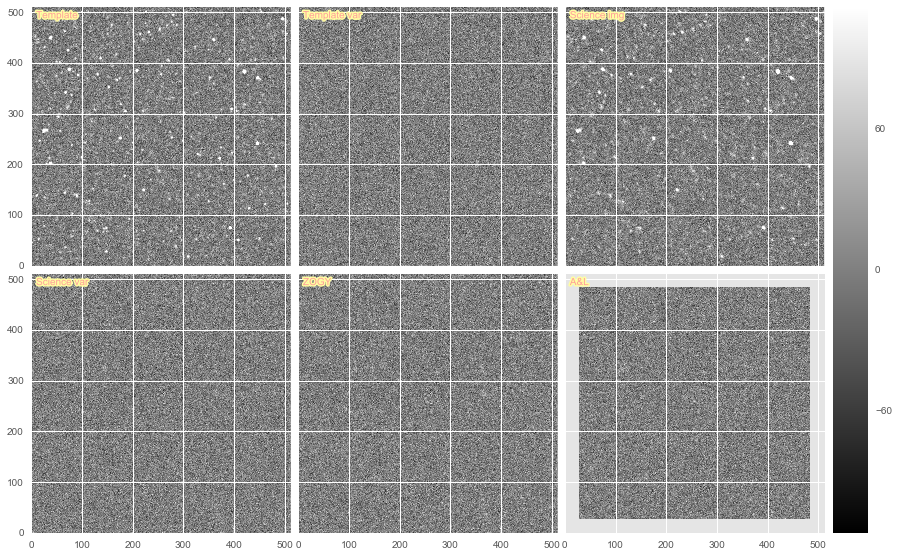

In [4]:
reload(dit);
testObj = dit.DiffimTest(skyLimited=True)
res = testObj.runTest()
print res
fig = plt.figure(1, (15, 15))
testObj.doPlot()

Try both...

{'ZOGY': {'FP': 6, 'FN': 20, 'TP': 30}, 'ALstack': {'FP': 5, 'FN': 30, 'TP': 20}, 'SZOGY': {'FP': 10, 'FN': 23, 'TP': 27}, 'ALstack_noDecorr': {'FP': 4, 'FN': 23, 'TP': 27}}
300.0 0.0


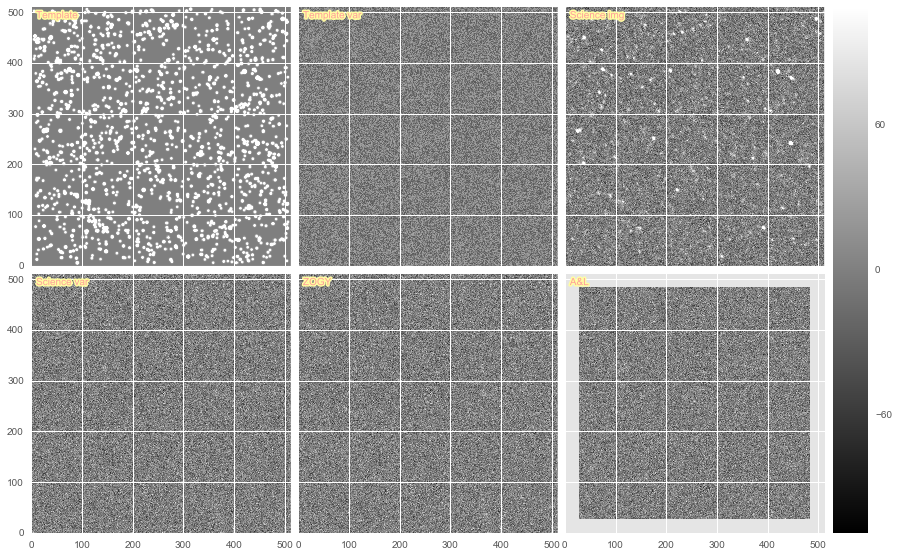

In [5]:
reload(dit);
testObj = dit.DiffimTest(templateNoNoise=True, skyLimited=True)
res = testObj.runTest()
print res
print np.mean(testObj.im1.var), np.std(testObj.im1.var)
testObj.im1.var += np.random.uniform(size=testObj.im1.var.shape)  # need to make it so we can plot it.
fig = plt.figure(1, (15, 15))
testObj.doPlot()

In [6]:
# Default 10 sources with same flux
def runTest(flux, seed=66, n_varSources=50):
    testObj = dit.DiffimTest(varFlux2=np.repeat(flux, n_varSources), seed=seed,
                            templateNoNoise=True, skyLimited=True)
    det = testObj.runTest()
    det['flux'] = flux
    return det

methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

In [7]:
inputs = [(f, seed) for f in [750.] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1]) for i in inputs)

100


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  7.1min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 19.4min finished


FN: 
ALstack             26.46
ALstack_noDecorr    22.77
SZOGY               19.57
ZOGY                19.40
dtype: float64
FP: 
ALstack             4.61
ALstack_noDecorr    5.05
SZOGY               7.53
ZOGY                6.78
dtype: float64
TP: 
ALstack             23.54
ALstack_noDecorr    27.22
SZOGY               30.41
ZOGY                30.58
dtype: float64


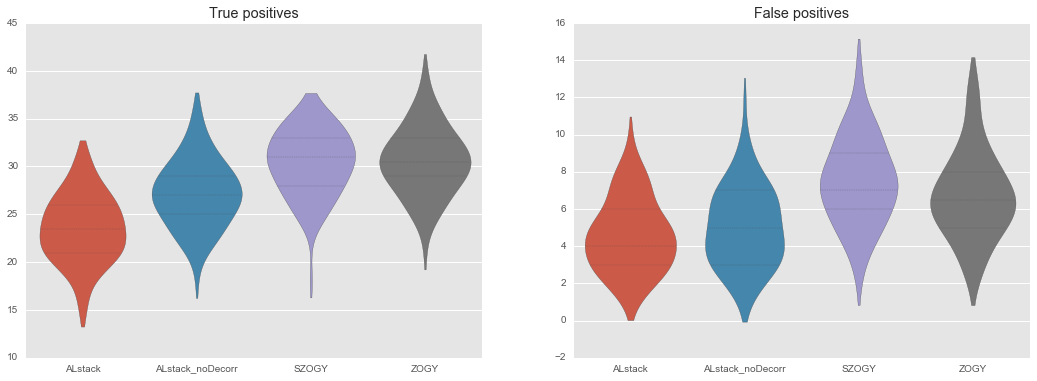

In [8]:
def plotResults(tr):
    FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
    FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})
    TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
    print 'FN:', '\n', FN.mean()
    print 'FP:', '\n', FP.mean()
    print 'TP:', '\n', TP.mean()

    matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
    fig, axes = plt.subplots(nrows=1, ncols=2)

    sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
    axes[0].set_title('True positives')
    #axes[0].set_ylim((0, 31))
    sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
    axes[1].set_title('False positives')
    #axes[1].set_ylim((-1, 15))
    
plotResults(testResults1)